# DSML 4220 - Lab 2: A Multi-layer Perceptron (MLP) for Classifying Yelp Reviews

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/DSML4220/blob/main/lab2_mlp_for_yelp_reviews.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/DSML4220/blob/main/lab2_mlp_for_yelp_reviews.ipynb)

In this notebook we'll build off of a simple perceptron model we have seen and to create a PyTorch multilayer perceptron model. The dataset is similar to our airline tweets but larger in two ways. One, each observataion may have much more than 140 words. Two, there are now more than 50,000 observations.

Note that the code and data in this notebook is derived from [this notebook](https://github.com/delip/PyTorchNLPBook/blob/master/chapters/chapter_3/3_5_Classifying_Yelp_Review_Sentiment.ipynb) in the [repository for the book, NLP with PyTorch](https://github.com/delip/PyTorchNLPBook).


### Lab 2 Assignment/Task
Your task for this lab is to:
* add another layer to the model ([here](#definemodel)), ideally to try to improve the performance, and
* answer the [one question](#onequestion) at the very bottom of the notebook.

You will save your completed notebook (on Kaggle) and submit the link in Canvas. Note that although the only thing you really need to do is add another layer, you can/should also try experimenting with some hyperparameters such as the learning rate and batch size.

It is recommended that you work through the entire notebook once to get a sense of it all before making any modifications.

## Imports

In [2]:
from argparse import Namespace
from collections import Counter
from nltk.corpus import stopwords
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt

## Data Vectorization classes

### The Vocabulary

In [4]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [5]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hit vector for the review

        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)

        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=20):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        stop_words = set(stopwords.words('english'))

        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff and word not in stop_words:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary

        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching

        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

### The Dataset

In [6]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer.
        Used in the case in the vectorizer has been cached for re-use

        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file

        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json

        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe

        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
    ensure each tensor is at the correct device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Defining the Model Class

As with other examples we saw, the typical approach with PyTorch is to inherit from the `nn.Module` baseclass. This is then extended and customized per your model's architecture (e.g. how many layers, units per layer, etc.) and task (e.g. output layer and activation function).

<a id="definemodel"></a>

In [8]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features, hidden_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=16)
        #self.fc2 =
        self.fc3 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        out = self.fc1(x_in)
        out = F.relu(out)

        # be sure that your new hidden layer, fc2, is used in the forward pass!

        y_out = self.fc3(out).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

## Training Routine


### Helper functions

In [9]:
def make_train_state(args):
    return {'stop_early': True,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e6,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### General utilities

A couple of general helper functions. The first, which sets the random seed is important since you will generally want to be able recreate a model training run exactly. Because there are so many places where random number generation is needed though (e.g. initial weight values, sampling of batches, etc.) it is important the the random seed is set so that the exact same random numbers are generated. Note that both `numpy` and `PyTorch` each have their own random number generation, so both need to be set.

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and prep work

In [11]:
# Setup information about how to name and locate data, hyperparams, etc.
args = Namespace(
    # Input data file (from preprocessing step)
    #input_data_path='gdrive/MyDrive/Colab Data/',
    input_data_path='~/data/',
    review_csv='https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/yelp_reviews.csv',
    # Output data and path information
    #frequency_cutoff=25,
    model_state_file='model.pth',
    #save_dir='gdrive/MyDrive/Colab Data/yelp_models/',
    save_dir='~/data/dsml4220/',
    vectorizer_file='vectorizer.json',
    # Training hyper parameters
    batch_size=1000,
    early_stopping_criteria=3,
    learning_rate=0.001,
    num_epochs=6,
    seed=42,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

# Expand out the paths and confirm they are correct
if args.expand_filepaths_to_save_dir:
    if 'https' not in args.review_csv:
        args.review_csv = os.path.join(args.input_data_path, args.review_csv)
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.review_csv))
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/yelp_reviews.csv
	~/data/dsml4220/vectorizer.json
	~/data/dsml4220/model.pth
Using CUDA: False


### Initializations

In [14]:
# if the cell below has an error due to nltk stopwords, then uncomment the followign lines and run them, then re-run the cell below

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()


Loading dataset and creating vectorizer


### Quick Data Exploration

In [16]:
dataset.review_df['review'][4]

'if i could give a of a star i would . the service is terrible ! we were first sat where it was freezing and the waiter was very unprofessional made it uncomfortable with stupid little remarks . we then moved to the bar area because that the only place you can get the happy hour appetizers , which isn t unheard of but would have been nice if the waiter promoted what they have . after ordering our main course i got shrimp and as the food came out they told me they were out of cocktail sauce . i then waited minutes for extra lemon which i never got because no one checked on us after the first time again . this was by far the worst experience i ve ever had anywhere . never again . save your money . '

In [17]:
dataset.review_df['rating'][4]

'negative'

In [18]:
dataset.test_df['review'].iloc[4]

'dr . tom is wonderful , at least the couple times i have been able to see her . nthey have so many patients that you can never get a appointment with your doctor , they are booked at least months out . it s about volume here . '

In [19]:
dataset.set_split('test')
dataset._target_df['review'].iloc[4]

'dr . tom is wonderful , at least the couple times i have been able to see her . nthey have so many patients that you can never get a appointment with your doctor , they are booked at least months out . it s about volume here . '

In [20]:
dataset[4]['x_data'].shape

(8137,)

In [21]:
for i, tokflag in enumerate(dataset[4]['x_data']):
    if tokflag > 0:
#        print(f" pos i={i:4.0f} has a non-zero token value of: {tokflag} (original tok was: {vectorizer.review_vocab._idx_to_token[i]})")
        print(f" pos i={i:4.0f} has token value of: {tokflag} (token was: {vectorizer.review_vocab.lookup_index(i)})")

 pos i=   0 has token value of: 1.0 (token was: <UNK>)
 pos i=  56 has token value of: 1.0 (token was: get)
 pos i= 251 has token value of: 1.0 (token was: couple)
 pos i= 286 has token value of: 1.0 (token was: never)
 pos i= 442 has token value of: 1.0 (token was: wonderful)
 pos i= 502 has token value of: 1.0 (token was: appointment)
 pos i= 514 has token value of: 1.0 (token was: doctor)
 pos i= 551 has token value of: 1.0 (token was: months)
 pos i= 576 has token value of: 1.0 (token was: least)
 pos i= 600 has token value of: 1.0 (token was: many)
 pos i= 646 has token value of: 1.0 (token was: see)
 pos i= 659 has token value of: 1.0 (token was: nthey)
 pos i= 812 has token value of: 1.0 (token was: times)
 pos i=1032 has token value of: 1.0 (token was: able)
 pos i=1047 has token value of: 1.0 (token was: volume)
 pos i=1305 has token value of: 1.0 (token was: dr)
 pos i=1320 has token value of: 1.0 (token was: patients)
 pos i=1351 has token value of: 1.0 (token was: tom)
 pos

In [22]:
#vectorizer.review_vocab._token_to_idx
for key, val in vectorizer.review_vocab._idx_to_token.items():
  if key < 30:
    print(f"{key:2.0f} -> {val}")

 0 -> <UNK>
 1 -> think
 2 -> filiberto
 3 -> good
 4 -> food
 5 -> like
 6 -> place
 7 -> tacos
 8 -> dry
 9 -> tasteless
10 -> lukewarm
11 -> beans
12 -> fluffy
13 -> rice
14 -> thing
15 -> love
16 -> gilbert
17 -> want
18 -> support
19 -> mom
20 -> pop
21 -> nhow
22 -> around
23 -> long
24 -> beyond
25 -> driven
26 -> years
27 -> figured
28 -> must
29 -> great


The `vectorizer` even stores the labels themselves (i.e. the Yelp review classification)  in Python dictionaries.

In [23]:
print(vectorizer.rating_vocab._idx_to_token)
print(vectorizer.rating_vocab._token_to_idx)

{0: 'negative', 1: 'positive'}
{'negative': 0, 'positive': 1}


### Training loop

Let's declare/instantiate our model in a cell separate from the training run itself so that we can re-run it indepedently of other set up steps. This way if we change model architecture we can simply re-run this cell.

To see how this model is defined, and how the variable `hidden_features` is used, go back to the [__Defining the Model Class__](#definemodel) section above.

__NOTE: The `hidden_features` variable is not yet used. When you create an additional hidden layer in this model, this is number that will define how many neurons are in your new hidden layer.__


In [24]:
classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab), hidden_features=64)

This large chunk of code is the training loop. Notice that there are two nested loops:

* the outer loop is for the number of epochs, or iterations over the _full_ dataset, and
* the inner loop is for (mini)batches, which are smaller subsets of the training data (and have the effect of alterign the loss surface each time a gradient descent update is done).

In [26]:
import tqdm.auto

classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size),
                          position=1,
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size),
                        position=1,
                        leave=True)

losses = {'train':[], 'val':[]}

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            losses['train'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            losses['val'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            val_bar.set_postfix(loss=running_loss,
                                acc=running_acc,
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])
        #optimizer.step()

        train_bar.n = 0
        val_bar.n = 0

        if train_state['stop_early']:
            print("Stopping early - validation is no longer significantly improving")
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/6 [00:00<?, ?it/s]

split=train:   0%|          | 0/39 [00:00<?, ?it/s]

split=val:   0%|          | 0/8 [00:00<?, ?it/s]

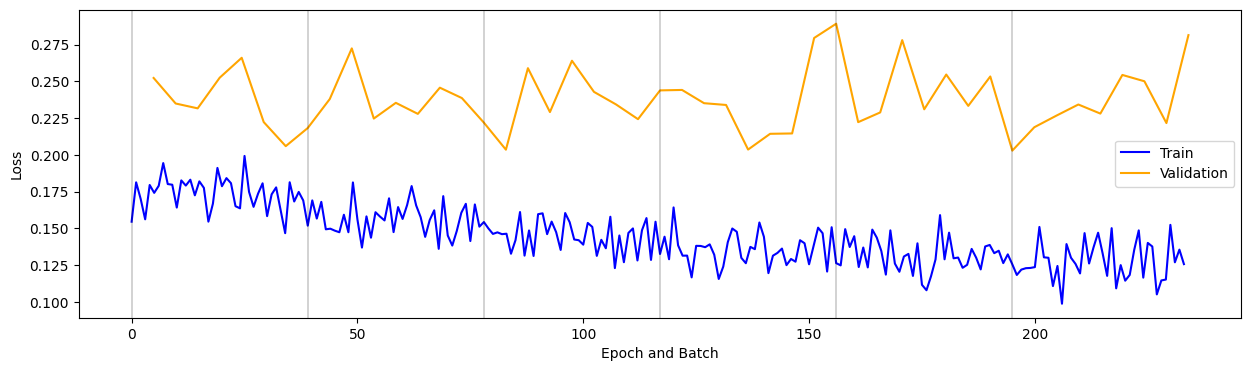

In [27]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue')
plt.plot(val_ticks, losses['val'], c='orange')
for i in range(args.num_epochs):
    plt.axvline(x=i*len(losses['train'])/args.num_epochs, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [28]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'], weights_only=True))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [29]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.239
Test Accuracy: 91.20


### Inference

In [30]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [31]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """Predict the rating of a review

    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)

    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))

    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [32]:
#test_review = "this is not a pretty awesome restaurant"
test_review = "the floors were a little bit dirty, but the food was far above average"
#test_review = "pizza century yum"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

the floors were a little bit dirty, but the food was far above average -> negative


### Interpretability

Let's look at the weigh values themselves to see if we can gain some kind of interpretability about the network. It's far from a legitimate form of model explainability, but just looking at the magnitudes of the weight values can tell us something. Namely, values farther away from zero will have greater impact in the subsequent layer, and (presumably) eventually the output.

We'll first look at large (positive) values, but since it's only the magnitude that has an effect we don't know for certain if these will correspond to positive sounding words or negative sounding words (i.e. words that will be associated with a positive/negative yelp review).

In [33]:
# Look at weights for first hidden unit in first hidden layer
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=False)
indices = indices.numpy().tolist()

# Top 20 words
print("Tokens with lowest corresponding parameter values (in first hidden unit of first layer):")
print("-------------------------------------------------------------")
for i in range(20):
    print(f"w_{i}: {fc1_weights[indices[i]]:.4f}, token: {vectorizer.review_vocab.lookup_index(indices[i])}")

indices.reverse()

# Top 20 negative words
print("\n\nTokens with highest corresponding parameter values (in first hidden unit of first layer):")
print("-------------------------------------------------------------")

for i in range(20):
    print(f"w_{i}: {fc1_weights[indices[i]]:.4f}, token: {vectorizer.review_vocab.lookup_index(indices[i])}")
    #print(vectorizer.review_vocab.lookup_index(indices[i]))

Tokens with lowest corresponding parameter values (in first hidden unit of first layer):
-------------------------------------------------------------
w_0: -0.2254, token: hooked
w_1: -0.2198, token: fantastic
w_2: -0.2169, token: delicious
w_3: -0.2125, token: amazing
w_4: -0.2112, token: pleasantly
w_5: -0.2069, token: excellent
w_6: -0.1946, token: great
w_7: -0.1940, token: haha
w_8: -0.1928, token: pleased
w_9: -0.1893, token: awesome
w_10: -0.1861, token: yum
w_11: -0.1860, token: ngreat
w_12: -0.1833, token: boba
w_13: -0.1829, token: heavenly
w_14: -0.1811, token: solid
w_15: -0.1800, token: vegas
w_16: -0.1796, token: perfect
w_17: -0.1789, token: thorough
w_18: -0.1769, token: pho
w_19: -0.1754, token: perfection


Tokens with highest corresponding parameter values (in first hidden unit of first layer):
-------------------------------------------------------------
w_0: 0.2607, token: meh
w_1: 0.2591, token: bland
w_2: 0.2580, token: worst
w_3: 0.2547, token: awful
w_4: 0.2513

In [35]:
# if this cell does not run the first time, then uncomment the following line and re-run it
!pip install torchinfo
import torchinfo
summ = torchinfo.summary(classifier, (1, dataset[0]['x_data'].shape[0]))
summ

Layer (type:depth-idx)                   Output Shape              Param #
ReviewClassifier                         --                        --
├─Linear: 1-1                            [1, 16]                   130,208
├─Linear: 1-2                            [1, 1]                    17
Total params: 130,225
Trainable params: 130,225
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.52
Estimated Total Size (MB): 0.55

#### Q: How many parameters are in the first layer of your model (after you added a new hidden layer)?

Fix the code cell below so that you get the same result as shown by `torchinfo` above.

<a id="onequestion"></a>

In [37]:
n_params_in_layer1_weighmatrix = 8137 * 16
n_params_in_layer1_bias_vector = 16
n_params_in_layer1_weighmatrix + n_params_in_layer1_bias_vector

130208

The shape of the input size can be verified by looking at the shape of a single observation:

In [38]:
dataset[0]['x_data'].shape[0]

8137

### End

Before finishing let's quickly look at the weight matrix in the first layer.

In order to avoid numerical precision issues (numbers becoming too large or too small for a computer to store), that the weight values are always centered around zero between -1 and 1 (but not too close to zero).

In [39]:
fc1_weights = classifier.fc1.weight.detach()
fc1_weights.shape

torch.Size([16, 8137])

Based on the shape given above, does the following output show us all of the weights for a single token in the vocabulary going into all of the first hidden layer's units?
    
Or, is it showing us all of the weights for a single hidden unit coming from all possible tokens in the vocabulary?

In [40]:
fc1_weights.numpy()[:,0]

array([0.16631131, 0.1044345 , 0.17513506, 0.10576806, 0.10301608,
       0.09667093, 0.11570672, 0.16220082, 0.18880194, 0.19623557,
       0.16661692, 0.15660794, 0.15904123, 0.13071615, 0.09179995,
       0.09412435], dtype=float32)